In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2020-09-20 18:55.


In [2]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [3]:
## ----- Setup working dir
sp_name = "0_Acute-Chronic"
analysis_name = ["0", "resampled"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

0_Acute-Chronic


In [4]:
###----- old - new cluster names
order_file ='%s/%s/2_scVelo'%(base_dir, sp_name) + '/%s_scVelo_out_%s/pt_ordered_cluster_avg.csv'%(analysis_name[0], analysis_name[1])
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

# 1. Scatterplots

In [5]:
adata_h5ad = '%s/%s/1_Scanpy'%(base_dir, sp_name) + '/%s_Scanpy_out_%s/%s_paga.h5ad'%(analysis_name[0], analysis_name[1], sp_name)
adata = sc.read_h5ad(adata_h5ad)

#--- Match old & new louvain levels
adata.obs['louvain_old'] = adata.obs['louvain']
adata.uns['louvain_old_colors'] = adata.uns['louvain_colors']
adata.obs['louvain'] = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in adata.obs['louvain'] ]
category_order = order_df.sort_values('louvain')['louvain_new_label'].tolist()
adata.obs['louvain'] = pd.Categorical(adata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

adata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in adata.obs['cell_type']]
adata.obs['cell_id'] = adata.obs.index.tolist()

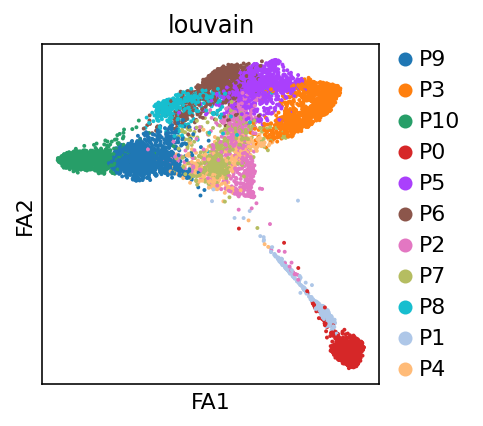

In [10]:
### New louvain cluster numeric order plot
save_name = '_louvain_new_scatter_with_leg.png'

### Plot
rcParams['figure.figsize'] = 3, 3

sc.pl.draw_graph(adata, color=['louvain'], save = save_name )

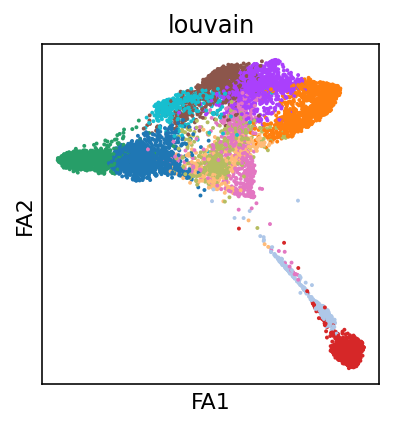

In [11]:
### New louvain cluster numeric order plot
save_name = '_louvain_new_scatter.png'

### Plot
rcParams['figure.figsize'] = 3, 3

sc.pl.draw_graph(adata, color=['louvain'], legend_loc = "none", save = save_name )

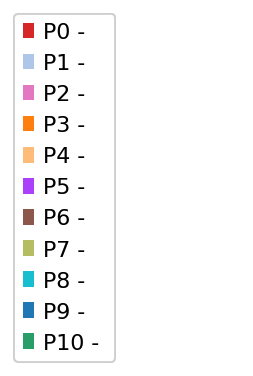

In [12]:
### New louvain cluster numeric order legend
save_name = 'louvain_new_scatter_leg.png'

### Plot
fig, ax=plt.subplots(figsize=(2,3))

phenotype_labels = ["" for x in louvain_new_ordered]

cpatch_elements = []
for i in range(0,len(louvain_new_ordered)):
    cpatch_elements.append(Patch(facecolor=adata.uns['louvain_colors'][louvain_old_ordered[i]], label="%s - %s" %(louvain_new_ordered[i], phenotype_labels[i])))

ax.add_artist(ax.legend(handles=cpatch_elements, loc=[0,0]))
ax.axis('off')
plt.show()
fig.savefig("figures/%s"%save_name)
plt.close()

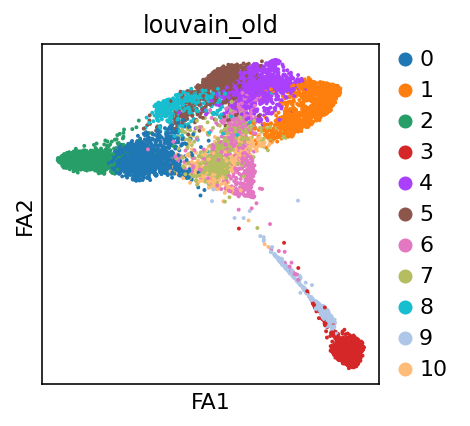

In [13]:
### Original louvain cluster numeric order
save_name = '_louvain_old_scatter.png'

### Plot
rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['louvain_old'], save=save_name)

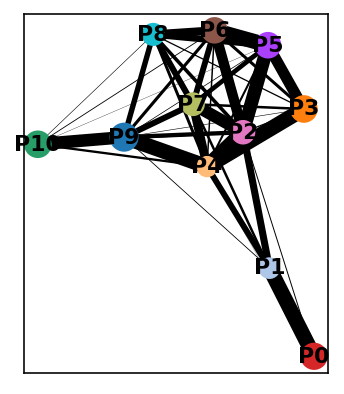

In [14]:
### New louvain cluster numeric order - Node plot
save_name = 'louvain_new_node.png'

### Plot
rcParams['figure.figsize'] = 3, 3
sc.pl.paga(adata, color=['louvain'], save=save_name)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

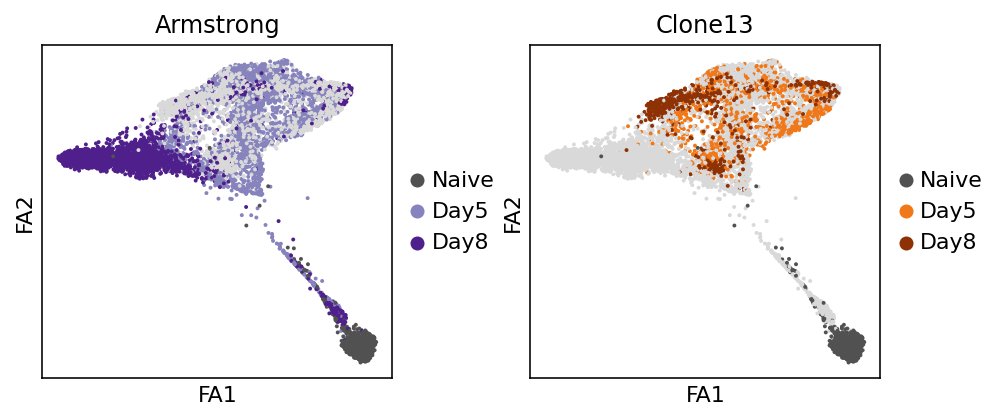

In [15]:
### Hightlight by day
save_name = '_Arm_vs_Cl13---byDay.png'

### Plot
adata.obs['Armstrong'] = [x if "C" not in x else "" for x in adata.obs['cell_type']]
adata.obs['Armstrong'] = ["Naive" if x == 'NP14B' else "" if x == "" else "Day%s"%x[1] for x in adata.obs['Armstrong']]
adata.obs['Armstrong'] = pd.Categorical(adata.obs['Armstrong'].tolist(), categories=['', 'Naive','Day5', 'Day8']) 
adata.uns['Armstrong_colors'] = [plt.cm.Greys(0.25), plt.cm.Greys(0.75), plt.cm.Purples(0.6), plt.cm.Purples(0.9)]

adata.obs['Clone13'] = [x if "A" not in x else "" for x in adata.obs['cell_type']]
adata.obs['Clone13'] = ["Naive" if x == 'NP14B' else "" if x == "" else "Day%s"%x[1] for x in adata.obs['Clone13']]
adata.obs['Clone13'] = pd.Categorical(adata.obs['Clone13'].tolist(), categories=['', 'Naive','Day5', 'Day8']) 
adata.uns['Clone13_colors'] = [plt.cm.Greys(0.25), plt.cm.Greys(0.75), plt.cm.YlOrBr(0.6),  plt.cm.YlOrBr(0.9)]

rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['Armstrong', 'Clone13'], save=save_name)

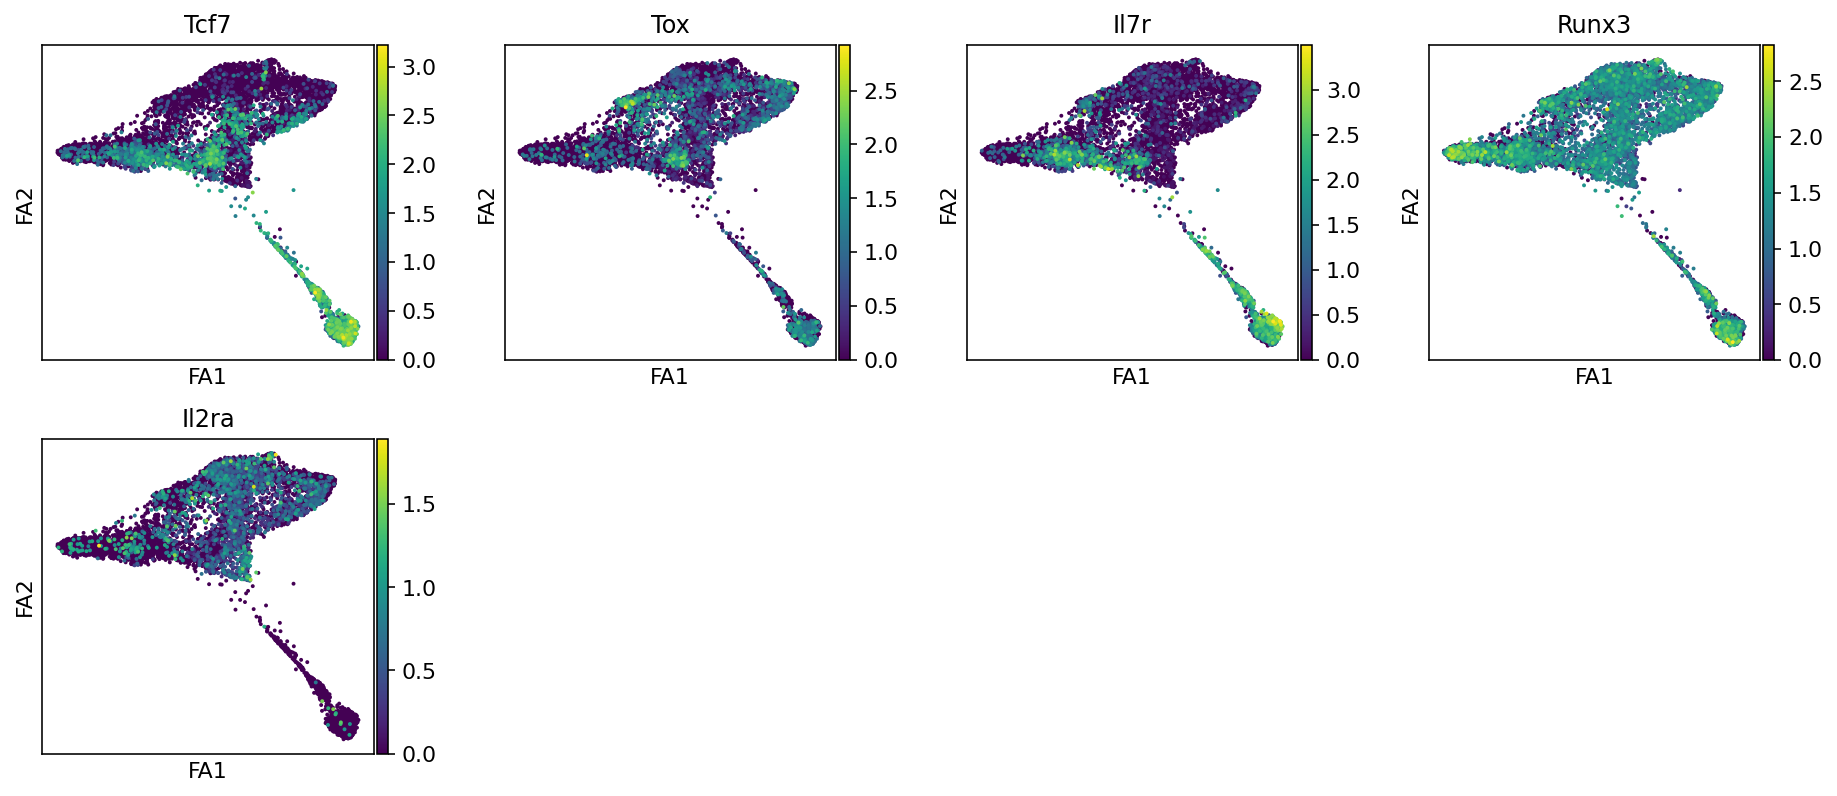

In [34]:
### Scatter plot with signature genes
save_name = 'Slt_genes_scatter.png'

### Plot
rcParams['figure.figsize'] = 3, 3
slt_genes = ['Tcf7', 'Tox', 'Il7r', 'Runx3', 'Il2ra']
sc.pl.draw_graph(adata, color=slt_genes, color_map='viridis', save=save_name)

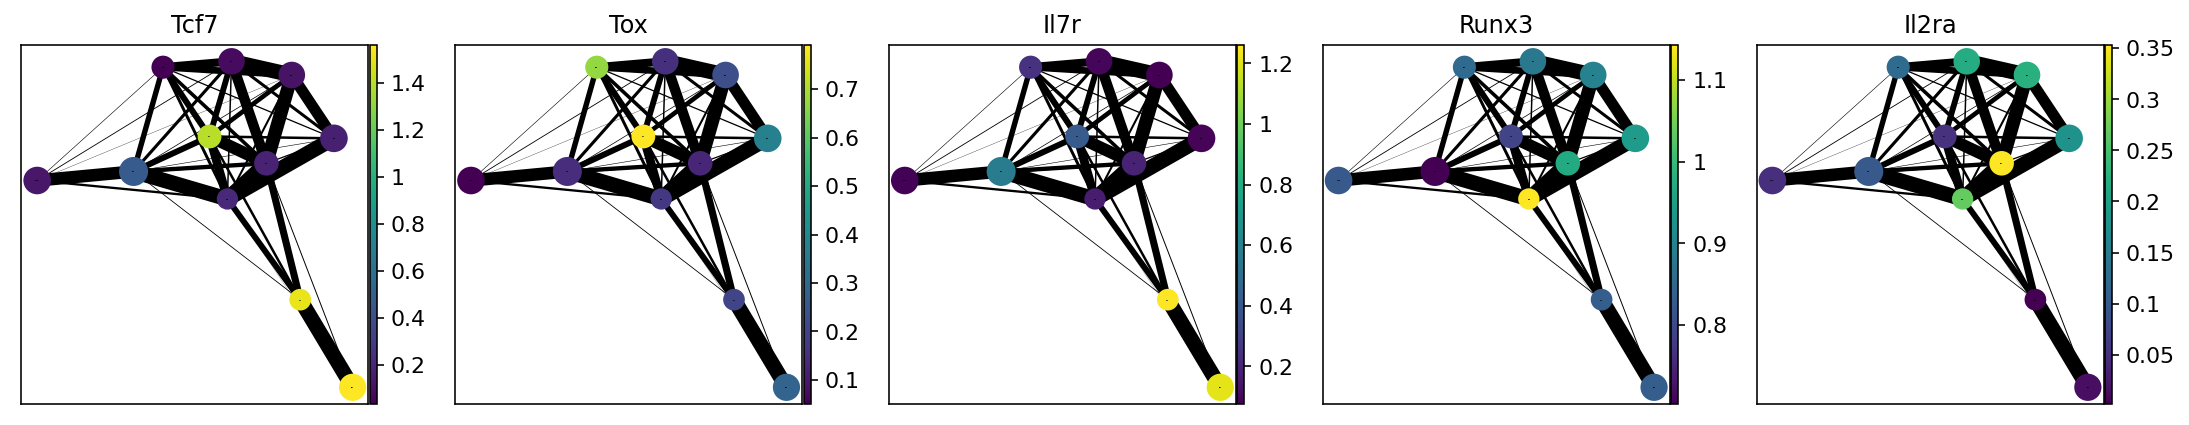

In [33]:
### Node plot with signature genes
save_name = 'Slt_genes_node.png'

### Plot
rcParams['figure.figsize'] = 3.3, 3
slt_genes = ['Tcf7', 'Tox', 'Il7r', 'Runx3', 'Il2ra']
sc.pl.paga(adata, color=slt_genes, fontsize=0, cmap='viridis')

## 2. Distribution

In [35]:
adata.obs['cell_type_plot'] = ['Naive' if x =='NP14B' else x for x in adata.obs['cell_type']]
adata.obs['cell_type_plot'] = [x[:2] if x != 'Naive' else x for x in adata.obs['cell_type_plot']]
cell_type_plot_order = ['Naive', 'A5', 'A8', 'C5', 'C8']
adata.obs['cell_type_plot'] = pd.Categorical(adata.obs['cell_type_plot'].tolist(), categories=cell_type_plot_order)

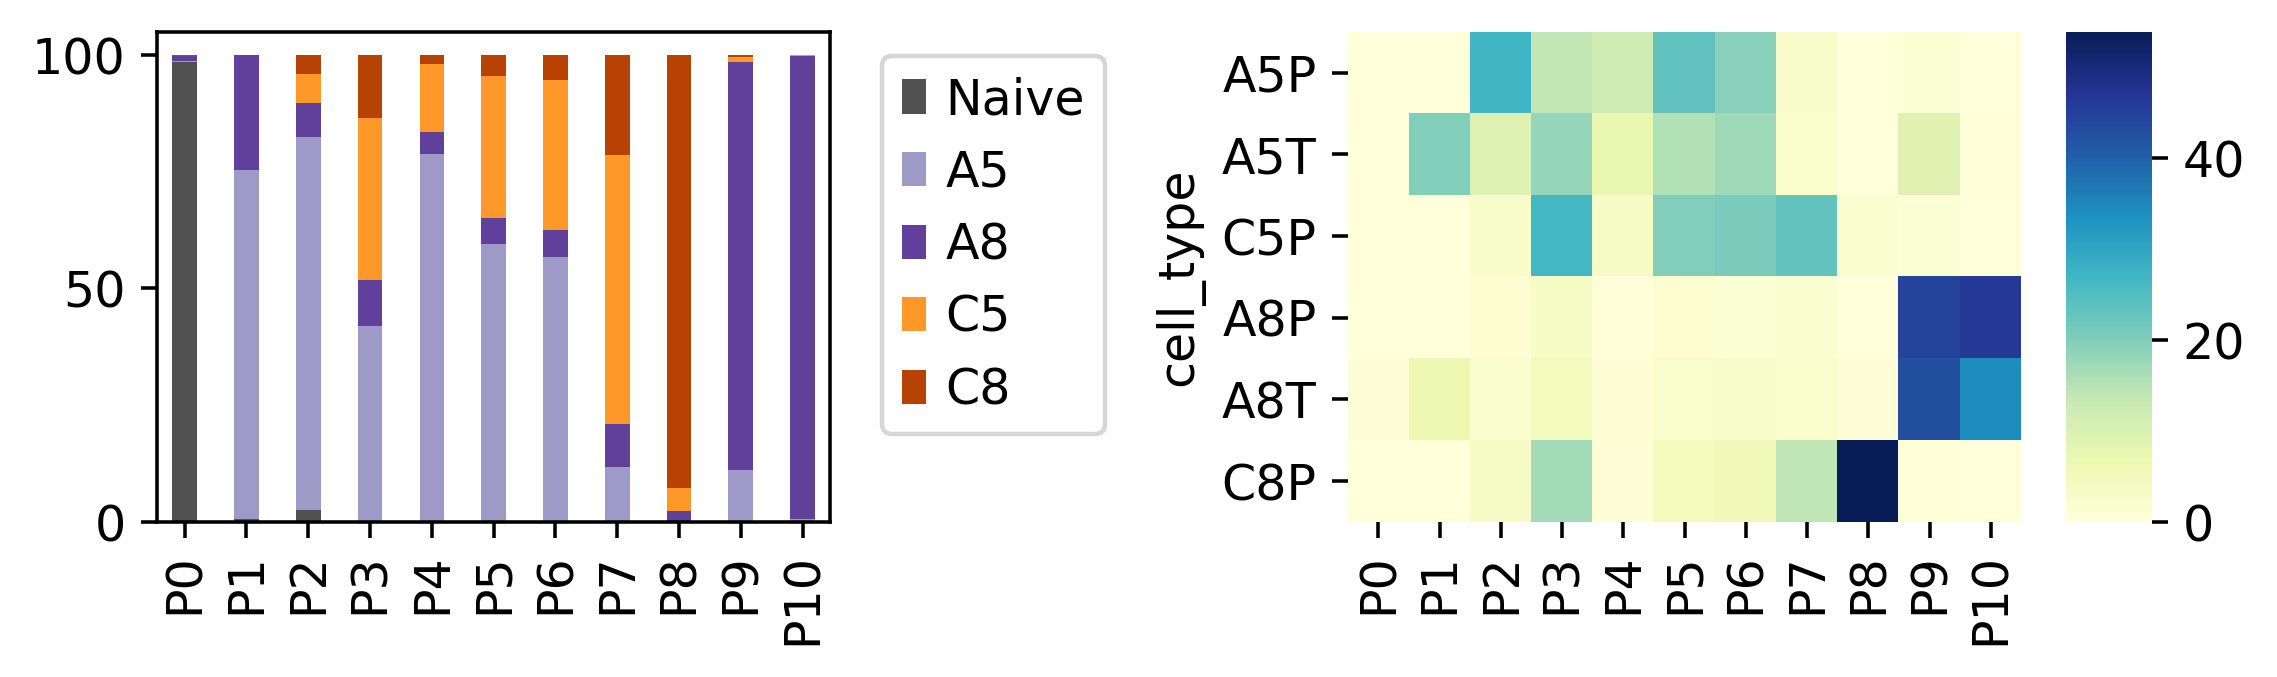

In [89]:
### Hightlight by day
save_name = 'Louvain_cell-type_distribution.png'

### Plot
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=False, figsize=(7,2), constrained_layout = True, dpi=160)

col_list = [plt.cm.Greys(0.75), plt.cm.Purples(0.5), plt.cm.Purples(0.8),  plt.cm.YlOrBr(0.5),  plt.cm.YlOrBr(0.8)]
sum_df = sc_pl_addons.count_pctg_stack_bars(adata,  'louvain', 'cell_type_plot','cell_id', 
                                   None, None, axes[0], col_list,True)

key1 = 'louvain'
key2 = 'cell_type'
count = 'cell_id'
sum_df = adata.obs.reset_index()[[key1, key2, count]].drop_duplicates(count).groupby([key1, key2]).count()[[count]].unstack(key1)
sum_df.columns = [x[1] for x in sum_df.columns.values] 
sum_df[np.isnan(sum_df)] = 0
for i in range(0, len(sum_df)):
    sum_df.iloc[i] = sum_df.iloc[i] / sum(sum_df.iloc[i]) * 100
sum_df_cols = sum_df.columns.tolist()
sum_df_cols = sorted(sum_df_cols, key=lambda x: int(re.findall("\d+", x)[0]))
sum_df = sum_df[sum_df_cols]

sum_df_plot = sum_df.loc[['A5P', 'A5T', 'C5P', 'A8P', 'A8T', 'C8P'], :]
sns.heatmap(sum_df_plot, cmap='YlGnBu', ax=axes[1])


plt.show()
fig.savefig(save_name)
plt.close()